# Think, Say, See it! Multi-model Gen AI w/ Intel HW & OpenVINO

This notebook demonstrates how to chain multiple Generative AI models together in OpenVINO with runtime in seconds on Intel CPUs and GPUs.

The pipeline is composed of four models:

1. [Whisper](https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/227-whisper-subtitles-generation/227-whisper-subtitles-generation.ipynb) for speech transcription
2. RedPajama for refining your text
3. Stable Diffusion [versions 2.1](https://github.com/openvinotoolkit/openvino_notebooks/tree/main/notebooks/236-stable-diffusion-v2) and [XL](https://github.com/openvinotoolkit/openvino_notebooks/tree/main/notebooks/248-stable-diffusion-xl) for using the text as a prompt for image generation
4. [CLIP](https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/232-clip-language-saliency-map/232-clip-language-saliency-map.ipynb) to explore interpretability of the generated image.

Whisper, RedPajama-INCITE, and CLIP is run on CPU, while the Stable Diffusion model is run on GPU.


To explore more of the details of the models and the OpenVINO implementation, check out the individual notebooks by clicking on the above hyperlinks.

![Hybrid AI Demo Flow](https://github.com/QData/TextAttack/assets/22090501/eb9a2e7e-504c-4e90-aeca-b3147ab3b0c5)

You can explore the Gradio notebook app accompanying this notebook [here](https://github.com/openvinotoolkit/openvino_notebooks/blob/conference-demos/conference-demos/intel-on-generative-ai/gradio_genai_pipeline.py). 

## Please Read: Important Prerequisites

This notebook and the accompanying Gradio demo assume **you already have OpenVINO model files** for Whisper and CLIP.

- Please ensure you have installed the necessary prerequisites for openvino notebooks via the repository's requirements.txt file.
- To obtain the quantized int8 OpenVINO IR models for Whisper, please follow the steps documented in [these 2 jupyter notebooks in the openvino_notebooks repo](https://github.com/openvinotoolkit/openvino_notebooks/tree/main/notebooks/227-whisper-subtitles-generation) and place the models in a directory called *whisper_models/*
- To obtain the CLIP models, please follow [this notebook in the openvino notebooks repo](https://github.com/openvinotoolkit/openvino_notebooks/tree/main/notebooks/232-clip-language-saliency-map) and place them in a directory called *clip/*.

**Note applying to folder size and contents used for storing models**: We use model caching with OpenVINO to help reduce delays - it exports the compiled model automatically and reuses it to significantly reduce the model compilation time. We use the same directory that we download the models in for caching as well.

## Table of Contents


In the first part of this notebook, we'll walk through the model setup, compilation, and inference steps in detail that are necessary when you first run this notebook 
In the final section, we'll see the inference pipeline in action withg ourmodelse already compiled and ready to us from the previous step! 

## Installation

In [1]:
from IPython import display

In [2]:
#Install the additional necessary prerequisites 
!pip install -r hybridai_demo_requirements.txt
display.clear_output()

In [7]:
from pathlib import Path
from openvino.runtime import Core, Tensor
import numpy as np
import time
from collections import namedtuple
from functools import partial

In [8]:
ie = Core()
#Select your device
import ipywidgets as widgets

device_names = [f"{device}: {ie.get_property(device, 'FULL_DEVICE_NAME')}" 
                for device in ie.available_devices]

print("Your available devices: \n", device_names)

Your available devices: 
 ['CPU: Intel(R) Xeon(R) Silver 4416+', 'GPU: Intel(R) Data Center GPU Flex 170 (dGPU)']


## Step 1: "Say it" with Whisper!

Whisper is an automatic speech recognition (ASR) system trained on 680,000 hours of multilingual and multitask supervised data collected from the web. 

### Step 1.1: Model setup
Whisper is a Transformer based encoder-decoder model, also referred to as a sequence-to-sequence model. It maps a sequence of audio spectrogram features to a sequence of text tokens. First, the raw audio inputs are converted to a log-Mel spectrogram by action of the feature extractor. Then, the Transformer encoder encodes the spectrogram to form a sequence of encoder hidden states. Finally, the decoder autoregressively predicts text tokens, conditional on both the previous tokens and the encoder hidden states.

Given that we have our OpenVINO Whisper model (with INT8 precision) files ready, we will import the whisper lib, replace the original models with the OpenVINO IR versions, and then reuse the original model pipeline for audio transcribing. 


First we'll start by recording **your audio input**. You can also skip this block and use a pre-recorded audio file below.

In [3]:
#!pip install PyAudio


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import pyaudio
import wave

chunk = 1024
sample_format = pyaudio.paInt16
channels = 2
fs = 44100
seconds = 5 #Adjust the number of seconds
filename = "output.wav"
p = pyaudio.PyAudio()
print('Starting Recording')
stream = p.open(format=sample_format,
                channels=channels,
                rate=fs,
                frames_per_buffer=chunk,
                input=True)
frames = []
for i in range(0, int(fs / chunk * seconds)):
    data = stream.read(chunk)
    frames.append(data)
stream.stop_stream()
stream.close()
p.terminate()
print('Recording Complete')
wf = wave.open(filename, 'wb')
wf.setnchannels(channels)
wf.setsampwidth(p.get_sample_size(sample_format))
wf.setframerate(fs)
wf.writeframes(b''.join(frames))
wf.close()

Starting Recording
Recording Complete


In [9]:
#audio_file = Path("output.wav")
#If you want to use a pre-recorded audio file, you can do so
audio_file = Path("mountain.wav")

In [10]:
#Download whisper base model
import whisper
whisper_model = whisper.load_model("base")
whisper_model.to("cpu")
whisper_model.eval()
pass
del whisper_model.decoder
del whisper_model.encoder

In [11]:
from utils.whisper_OV_utils import *
from utils.whisper_preprocess_utils import *

ie.set_property({'CACHE_DIR': 'whisper_models/'})
whisper_model = whisper.load_model("base").to("cpu").eval()
patch_whisper_for_ov_inference(whisper_model)
whisper_model.encoder = OpenVINOAudioEncoder(ie, 'whisper_models/whisper_encoder_int8.xml', device="CPU")
whisper_model.decoder = OpenVINOTextDecoder(ie, 'whisper_models/whisper_decoder_int8.xml', device="CPU")

### Step 1.2: Run the pipeline

Let's create a function for the inference of our Whisper function and get our transcribed text using the `.transcribe()` function.

In [12]:
def whisper_inference(whisper_model, audio_file):
    audio = resample_wav(audio_file)
    t1 = time.perf_counter()
    transcription = whisper_model.transcribe(audio, beam_size=5, best_of=5, task="translate")
    t2 = time.perf_counter()
    srt_lines = prepare_srt(transcription)
    # save transcription
    with audio_file.with_suffix(".srt").open("w") as f:
        f.writelines(srt_lines)
    transcribed_txt = "".join(srt_lines)
    print(transcribed_txt)
    print(f"It took {t2 - t1}s")
    return transcribed_txt

In [13]:
widgets.Audio.from_file(audio_file, loop=False)

Audio(value=b'RIFF\x90\xac\x12\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x02\x00D\xac\x00\x00\x10\xb1\x02\x00\x04\x0…

In [14]:
transcribed_txt = whisper_inference(whisper_model, audio_file)

2023-09-14 12:47:02.566309: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-14 12:47:02.567871: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-14 12:47:02.592510: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-14 12:47:02.593857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 12:47:03.038592: W tensorflow/compiler/tf2t

 a mountain landscape in an impressionist style
It took 1.6938745500519872s


## Step 2: "Refine it" with Red Pajama-INCITE (the Chat Version)

RedPajama-INCITE (3B) is a large language model for text generation - we'll be leveraging the chat version here. 

Using Optimum-Intel, we can obtain an FP16 or int8 precision OpenVINO model - here, we use int8 (Note: The process may take 3+ minutes). The model will be generated if it's not already present locally.

In [15]:
import time
from optimum.intel import OVQuantizer
from transformers import AutoModelForCausalLM
from optimum.intel.openvino import OVModelForCausalLM
from transformers import AutoTokenizer
from transformers import AutoConfig

model_id = "togethercomputer/RedPajama-INCITE-Chat-3B-v1"
redpj_tokenizer = AutoTokenizer.from_pretrained("togethercomputer/RedPajama-INCITE-Chat-3B-v1")

redPJ_REPO_DIR = Path("redpajama_chat_models")
if not redPJ_REPO_DIR.exists():
    #For int8 conversion
    #see https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/254-llm-chatbot/254-llm-chatbot.ipynb
    redpj_model = AutoModelForCausalLM.from_pretrained(model_id)
    quantizer = OVQuantizer.from_pretrained(redpj_model)
    quantizer.quantize(save_directory=redPJ_REPO_DIR, weights_only=True)
    gc.collect()
    
    #For FP16 conversion:
    #redpj_model = OVModelForCausalLM.from_pretrained(model_id, export=True, compile=False)
    #redpj_model.half()
    #redpj_model.save_pretrained(redPJ_REPO_DIR)
display.clear_output()

<div class="alert alert-block alert-info">
⚠️Compilation time for the RedPajama-INCITE model can exceed 1 minute. After running the compilation block once, you do not need to run it again for inference.
</d
</div>

In [16]:
ov_config = {'PERFORMANCE_HINT': 'LATENCY', 'NUM_STREAMS': '1', "CACHE_DIR": "redpajama_chat_models/"}
redpj_model = OVModelForCausalLM.from_pretrained(redPJ_REPO_DIR, device="CPU", ov_config=ov_config, use_cache=True, config=AutoConfig.from_pretrained(redPJ_REPO_DIR))

Compiling the model...


In [17]:
def redpj_inference(transcribed_txt, redpj_tokenizer, redpj_model):
    prompt = f"<human>: Write a prompt for a art generating AI model with the phrase '{transcribed_txt}' \
    Your answer should be a single, artistic sentence that adds text to the specified phrase.\n<bot>:"
    inputs = redpj_tokenizer(prompt, return_tensors='pt').to(redpj_model.device)
    input_length = inputs.input_ids.shape[1]
    t1 = time.perf_counter()
    outputs = redpj_model.generate(
        **inputs, max_new_tokens=20, do_sample=True, temperature=0.7, top_p=0.7, top_k=50, return_dict_in_generate=True
    )
    t2 = time.perf_counter()
    token = outputs.sequences[0, input_length:]
    output_str = redpj_tokenizer.decode(token)
    output_str = output_str.split(".")[0]
    print(output_str)
    print(f"It took {t2 - t1}s")
    return output_str

In [18]:
refined_txt = redpj_inference(transcribed_txt, redpj_tokenizer, redpj_model)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 A mountain landscape in an impressionist style
It took 2.029581106035039s


## Step 3: "See it" with Stable Diffusion!

Stable Diffusion v2 is the next generation of Stable Diffusion model a Text-to-Image latent diffusion model created by the researchers and engineers from Stability AI and LAION. 

In this section, we'll look at two options for Stable Diffusion: v2.1 and XL. We'll start by defining a generic function we can use with both options.


In [19]:
def sd_inference(refined_txt, model, img_path):
    # Generate an image. 
    image = model(refined_txt, num_inference_steps=15, height=512, width=512, 
                  generator=np.random.RandomState(314), output_type="pil").images[0]
    image.save("sd_result.png")
    return image

### Option 1: Stable Diffusion v2.1 

Stable Diffusion v2 provides great functionality over previous versions of Stable Diffusion (SD), including being able to use more data, employ more training, and has less restrictive filtering of the dataset. All of these features give us promising results for selecting a wide range of input text prompts.

The base model used for this example is the stabilityai/stable-diffusion-2-1-base. This model was converted to OpenVINO format, for accelerated inference on CPU or Intel GPU with OpenVINO's integration into Optimum: optimum-intel. The model weights are stored with FP16 precision, which reduces the size of the model by half.

In [20]:
from optimum.intel.openvino import OVStableDiffusionPipeline

# download the pre-converted SD v2.1 model from Hugging Face Hub
name = "helenai/stabilityai-stable-diffusion-2-1-base-ov"
sd_base_model_dir = Path("sd_2-1_base")

ov_config = {'PERFORMANCE_HINT': 'LATENCY', 'NUM_STREAMS': '1', "CACHE_DIR": "sd_2-1_base/"}

if not sd_base_model_dir.exists():
    sd_pipe = OVStableDiffusionPipeline.from_pretrained(name, compile=False, ov_config=ov_config, device="GPU")
    sd_pipe.reshape(batch_size=1, height=512, width=512, num_images_per_prompt=1)
    sd_pipe.half()
    sd_pipe.save_pretrained(sd_base_model_dir)
else:
    sd_pipe = OVStableDiffusionPipeline.from_pretrained(sd_base_model_dir, compile=False, ov_config=ov_config, device="GPU")
    sd_pipe.reshape(batch_size=1, height=512, width=512, num_images_per_prompt=1)

<div class="alert alert-block alert-info">
⚠️Compilation time can exceed 30s. After running the compilation block once, you do not need to run it again for inference.
</d
</div>

In [21]:
sd_pipe.compile()

Compiling the vae_decoder...
Compiling the unet...
Compiling the text_encoder...


  0%|          | 0/16 [00:00<?, ?it/s]

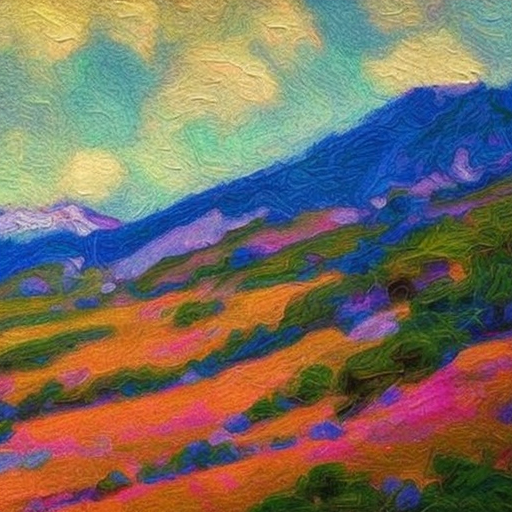

In [22]:
sd_inference(refined_txt, sd_pipe, "sd_result.png")

### Option 2: Stable DiffusionXL 

Stable Diffusion XL (SDXL) is the latest image generation model for more photorealistic outputs compared to previous Stable Diffusion models, including Stable Diffusion 2.1. SDXL leverages a three times larger UNet backbone, due to more attention blocks and a larger cross-attention context as SDXL uses a second text encoder. 


We'll use Optimum-Intel to downl and ad/load our bthe SDXL mo.

<div class="alert alert-block alert-info">
⚠️Compilation time can exceed 30s - 1 min for SDXL. After running the compilation block once, you do not need to run it again for inference.
</div>

In [36]:
from optimum.intel import OVStableDiffusionXLImg2ImgPipeline, OVStableDiffusionXLPipeline
import numpy as np

model_id = "stabilityai/stable-diffusion-xl-base-1.0"
model_dir = Path("sd-xl-base-1.0")

ov_config = {"EXECUTION_MODE_HINT": "ACCURACY", 'NUM_STREAMS': '1', "CACHE_DIR": "sd-xl-base-1.0/"}

if not model_dir.exists():
    sdxl_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_id, compile=False, device="GPU", ov_config=ov_config)
    sdxl_pipe.half()
    sdxl_pipe.save_pretrained(model_dir)
    sdxl_pipe.compile()
else:
    sdxl_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device="GPU", ov_config=ov_config)

Compiling the vae_decoder...
Compiling the unet...
Compiling the text_encoder...
Compiling the text_encoder_2...
Compiling the vae_encoder...


  0%|          | 0/15 [00:00<?, ?it/s]

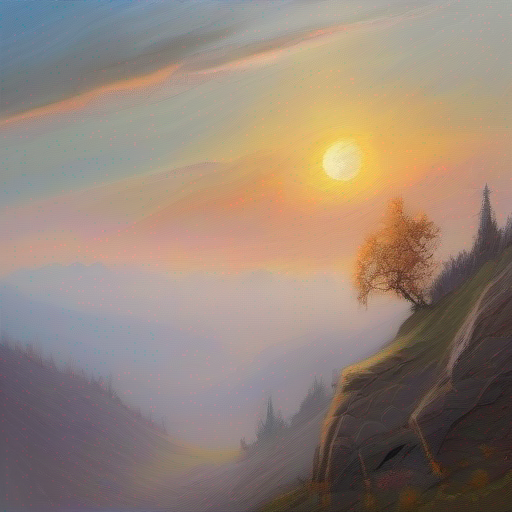

In [37]:
sd_inference(refined_txt, sdxl_pipe, "sd_result.png")

## Step 4: "Understand it" with CLIP!

CLIP (Contrastive Language–Image Pre-training) is a neural network that can work with both images and texts. It has been trained to predict which randomly sampled text snippets are close to a given image, meaning that a text better describes the image. We will explore language visual saliency with CLIP; a saliency map is a visualization technique that highlights regions of interest in an image.

We'll leverage the CLIP OpenVINO models that we already have locally, compile the models, and perform inference on the image generated from stable diffusion.


In [23]:
from transformers import CLIPProcessor
from PIL import Image
from utils.clip_utils import *

model_checkpoint = "openai/clip-vit-base-patch16"
processor = CLIPProcessor.from_pretrained(model_checkpoint)

In [27]:
core = Core()
core.set_property({'CACHE_DIR': 'clip/'})
#Load OpenVINO IRs for CLIP (our text and image models) and compile them
text_model = core.read_model("clip/clip-vit-base-patch16_text.xml")
image_model = core.read_model("clip/clip-vit-base-patch16_image.xml")
text_model = core.compile_model(model=text_model, device_name="CPU")
image_model = core.compile_model(model=image_model, device_name="CPU")

In [32]:
def clip_inference(query, img_path, text_model, image_model):
    #Run inference on the CLIP models
    image = Image.open(img_path)
    n_iters = 300
    min_crop_size = 50
    
    im_tensor = np.array(image)
    x_dim, y_dim = image.size
    text_inputs = dict(
        processor(text=[query], images=[im_tensor], return_tensors="np")
    )
    t1 = time.perf_counter()
    image_inputs = text_inputs.pop("pixel_values")
    
    text_embeds = text_model(text_inputs)[text_model.output()]
    image_embeds = image_model(image_inputs)[image_model.output()]
    
    initial_similarity = cosine_similarity(text_embeds, image_embeds)
    saliency_map = np.zeros((y_dim, x_dim))
    
    for _ in tqdm.notebook.tqdm(range(n_iters)):
        x, y, crop_size = get_random_crop_params(y_dim, x_dim, min_crop_size)
        im_crop = get_cropped_image(im_tensor, x, y, crop_size)
    
        image_inputs = processor(images=[im_crop], return_tensors="np").pixel_values
        image_embeds = image_model(image_inputs)[image_model.output()]
    
        similarity = cosine_similarity(text_embeds, image_embeds) - initial_similarity
        update_saliency_map(saliency_map, similarity, x, y, crop_size)
    t2 = time.perf_counter()
    plot_saliency_map(im_tensor, saliency_map, query, return_fig=False)
    print(f"It took {t2 - t1}s")

  0%|          | 0/300 [00:00<?, ?it/s]

It took 6.488677765009925s


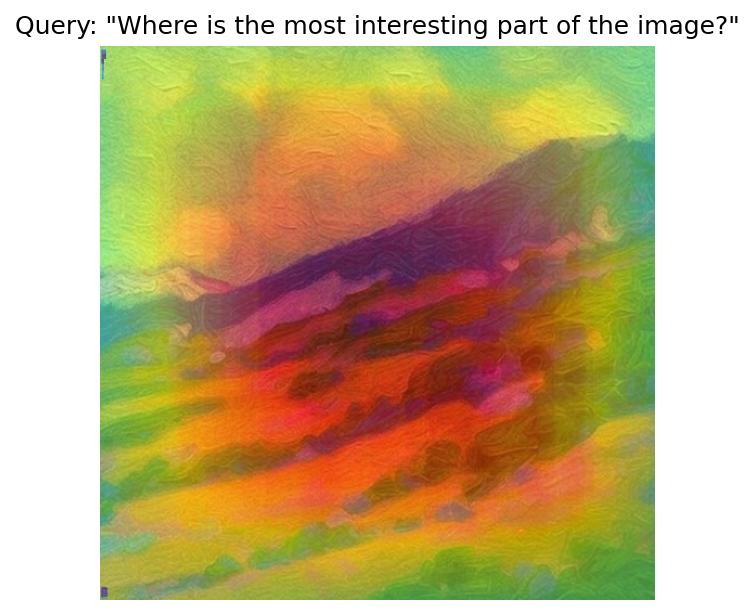

In [33]:
query = "Where is the most interesting part of the image?"
clip_inference(query, "sd_result.png", text_model, image_model)

# Put it all together: Inference-only with runtimes!

Now that we've setup and compiled our models, let's look at the final pipeline for inference-only.

In [34]:
#Use a pre-recorded audio file
#You can plug in your own audio here too!
audio_file = Path("mountain.wav")

---Whisper---


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 a mountain landscape in an impressionist style
It took 0.5435255661141127s
---Red Pajama-INCITE---
 A mountain landscape in an impressionist style, with a warm, glowing sun and a cool, mist
It took 2.0842799190431833s
---Stable Diffusion v2.1---


  0%|          | 0/16 [00:00<?, ?it/s]

---CLIP---


  0%|          | 0/300 [00:00<?, ?it/s]

It took 5.751634675078094s


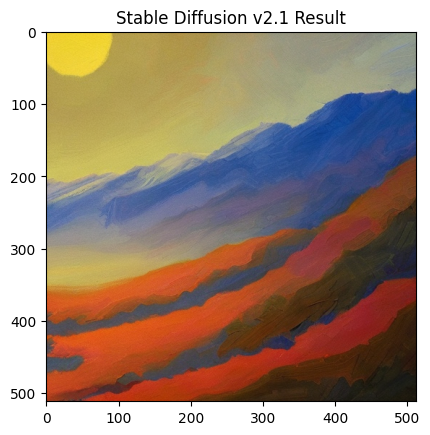

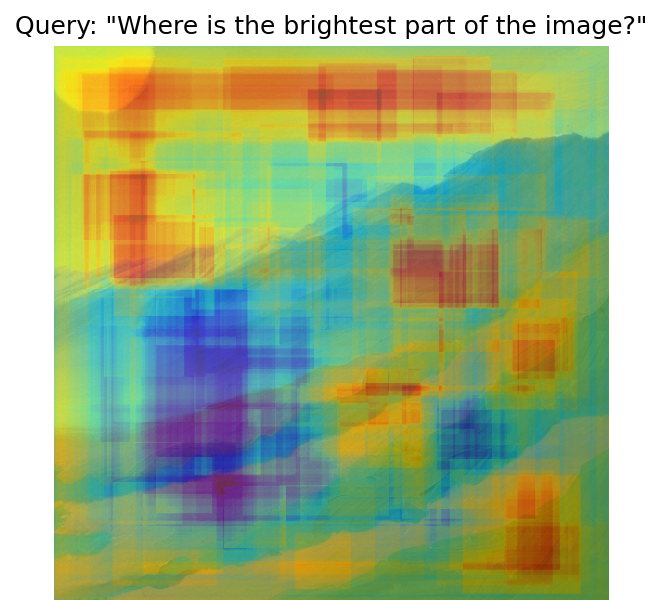

In [35]:
print("---Whisper---")
transcribed_txt = whisper_inference(whisper_model, audio_file)
print("---Red Pajama-INCITE---")
refined_txt = redpj_inference(transcribed_txt, redpj_tokenizer, redpj_model)
print("---Stable Diffusion v2.1---")
sd_image = sd_inference(refined_txt, sd_pipe, "sd_result.png")
plt.figure()
plt.title("Stable Diffusion v2.1 Result")
plt.imshow(sd_image)
print("---CLIP---")
clip_inference("Where is the brightest part of the image?", "sd_result.png", text_model, image_model)